In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy as sp
import template_funciones as tf

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [5]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

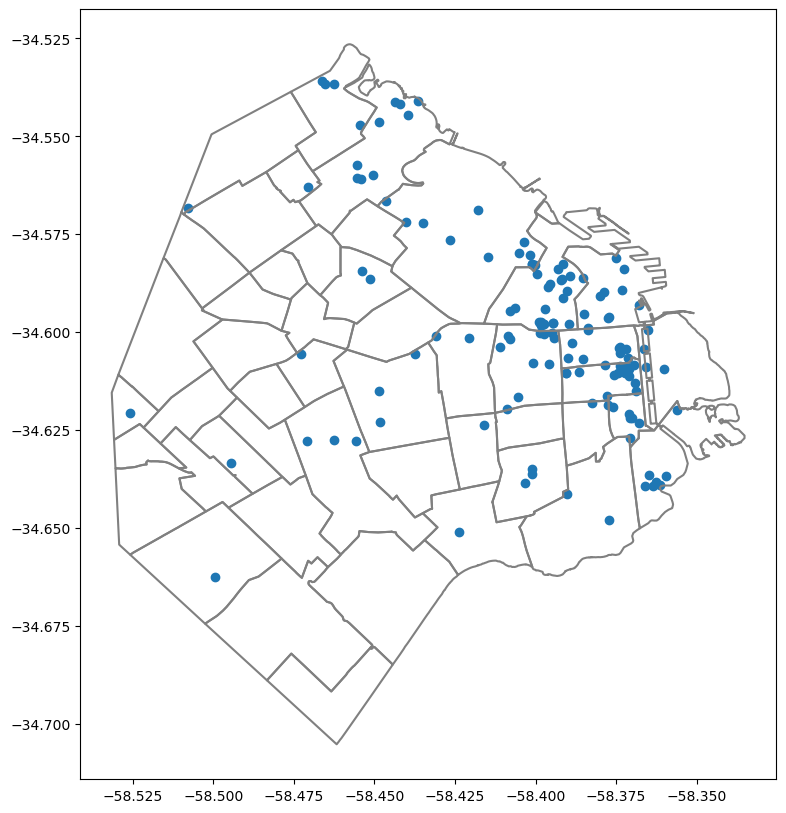

In [8]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [11]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [14]:
m = 3 # Cantidad de links por nodo
A = tf.construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [17]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

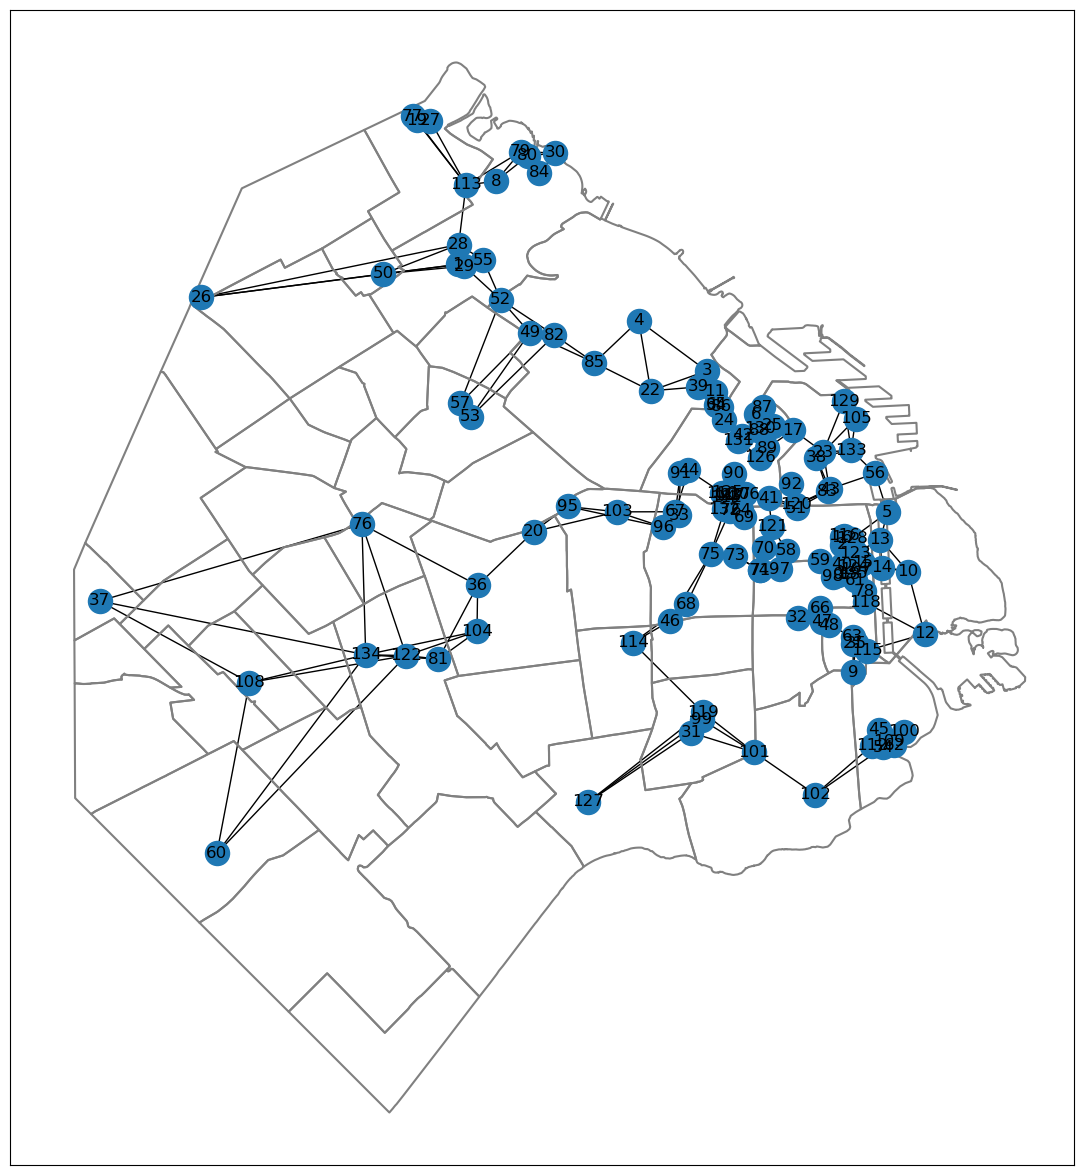

In [19]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:
Partiendo de la siguiente ecuación:
$$p=(1-\alpha)Cp+\frac\alpha N1$$
muestre que el vector de rankings $p$ es solución de la ecuación $Mp=b$, con $M=\frac{N}{\alpha}(I-(1-\alpha)C)$ y $b=1$.
### Respuesta
Queremos demostrar que la ecuación $p=(1-\alpha)Cp+\frac\alpha N1$ implica que el vector $p\in\mathbb{R}^N$ es solución de la ecuación $Mp=b$, con $M\in\mathbb{R}^{N \times N}:M=\frac N\alpha(I-(1-\alpha)C)$ y $b\in\mathbb{R}^N:b=1$. Para demostrar esto suponemos que el antecedente es verdadero, o sea que $p$ es el resultado de la ecuación dada por enunciado. Puesto que $N\in\mathbb{R}$ es un escalar que representa la cantidad de museos y $\alpha\in(0,1]$, entonces $\frac N\alpha\in\mathbb{R}$, y tenemos que la ecuación matricial que define a $p$ se puede desarrollar de la siguiente manera:
$$\begin{array}{ll}
	& p = (1-\alpha)Cp+\frac\alpha N1\\
	\implies & p-(1-\alpha)Cp=(1-\alpha)Cp+\frac\alpha N1-(1-\alpha)Cp\\
	\implies & p-(1-\alpha)Cp=\frac\alpha N1\\
	\implies & (I-(1-\alpha)C)p=\frac\alpha N1\\
	\implies & \frac N\alpha(I-(1-\alpha)C)p=\frac N\alpha\frac\alpha N1\\
	\implies & \frac N\alpha(I-(1-\alpha)C)p=1\\
	\implies & Mp=b
\end{array}$$
Y de este modo demostramos que si $p=(1-\alpha)Cp+\frac\alpha N1$, entonces $p$ es la solución de la ecuación lineal:
$$Mp=b,\quad\text{con } M=\frac N\alpha(I-(1-\alpha)C)\land b=1$$

## Punto 2:
¿Qué condiciones se deben cumplir para que exista una única solución a la ecuación del punto anterior? ¿Se cumplen estas condiciones para la matriz $M$ tal como fue construida para los museos, cuando $0<\alpha<1$? Demuestre que se cumplen o dé un contraejemplo.

### Respuesta
Para que el sistema lineal $Mp=b$ tenga solución única, la matriz $M$ debe ser **invertible**, lo cual es equivalente a que:
- $\text{det}(M)\neq0$
- el núcleo de $M$ debe ser trivial: $\text{Nu}(M)=\{0\}$

Para demostrar que estas condiciones se cumplen para la matriz $M$ cuando $\alpha\in(0,1)$, tenemos que verificar que la matriz $M$ es invertible. Como por enunciado tenemos que $M=\frac N\alpha(I-(1-\alpha)C)$, para demostrar su inversibilidad debemos analizar la matriz resultante de la resta $I-(1-\alpha)C$. Como $I$ es la matriz identidad, esta está constituida por $1$ en la diagonal. Luego, por enunciado tenemos que $C=A^t\cdot K^{-1}$, o sea que es el resultado del producto entre la matriz de adyacencia ($A$) y la matriz de movimientos ($K$). Conociendo las siguientes definiciones de las matrices $A$ y $K$:
$$\begin{array}{ll}
  & A_{ij}=\begin{cases}
    1, & \text{si }i\neq j\land j\in m-\text{cercanos}\\
    0, & \text{si }(i\neq j\land j\notin m-\text{cercanos})\lor i=j
  \end{cases}\\
  \implies & (A_{ij})^t=A_{ji}=\begin{cases}
    1, & \text{si }j\neq i\land j\in m-\text{cercanos}\\
    0, & \text{si }(j\neq i\land j\notin m-\text{cercanos})\lor j=i
  \end{cases}\\
  & K=\begin{cases}
    \sum_{h=1}^N A_{ih}, & i=j\\
    0, & i\neq j
  \end{cases}\\
  \implies & K^{-1}=\begin{cases}
    \sum_{h=1}^N \frac{1}{A_{ih}}, & i=j\\
    0, & i\neq j
  \end{cases}
\end{array}$$
Puesto que para cada fila $i$ de la matriz $A$ existen $m$ cantidad de unos, pues $A_{ij}$ es igual a 1 si el museo $j$ es parte del conjunto de $m$ museos mas cercanos a $i$, tenemos que $\sum_{h=1}^NA_ih=m$. Por lo tanto, $K_{ii}=m$ y $(K_{ii})^{-1}=\frac1m$.

Como $A_{ii}=0$ y $(K_{ij})^{-1}=0$ con $i\neq j$ tenemos que el producto $A^t\cdot K^{-1}$ tendrá en su diagonal valores nulos (i.e., $C_{ii}=0$). Luego, para los elementos fuera de la diagonal tenemos que $C_{ij}=\frac{A_{ji}}{m}$ con $i\neq j$. Luego como $A_{ji}$ está definido por casos, queda definido $C$ de la siguiente manera:
$$C_{ij}=\begin{cases}
  \frac{1}{m}, & \text{si } i\neq j\land j\in m-\text{cercanos}\\
  0, & \text{si } (i\neq j\land j\notin m-\text{cercanos})\lor j=i
\end{cases}$$

Como en la definición de la matriz $M$ tenemos que $C$ es modificado por el factor $(1-\alpha)$, con $\alpha\in(0,1)$, entonces dicho factor tambien pertenece al intervalo $(0,1)$. De este modo, el resultado de la multiplicación entre $(1-\alpha)$ y $C$ es la siguiente matriz:
$$\tilde{C}_{ij}=\begin{cases}
  \frac{1-\alpha}{m}, & \text{si }i\neq j\land j\in m-\text{cercanos}\\
  0, & \text{si }(i\neq j\land j\notin m-\text{cercanos})\lor j=i
\end{cases}$$
En consecuencia, la matriz $M$ queda definida como la resta entre $I$ y $\tilde{C}$, la cual puede ser definida de la siguiente manera:
$$M_{ij}=\begin{cases}
  1, &\text{si }i=j\\
  -\frac{1-\alpha}{m},&\text{si }i\neq j\land j\in m-\text{cercanos}\\
  0,&\text{si }i\neq j\land j\notin m-\text{cercanos}
\end{cases}$$
Siendo que $C$ es una matriz estocástica, tenemos que las columnas de la matriz suman 1 en su totalidad. Si además, $C$ es afectado por el escalar $(1-\alpha)<1$ tenemos que las columnas de $M$ fuera de su diagonal, suman un valor menor que 1. Teniendo en cuenta esta estructura de $M$, si analizamos $M^t$ deducimos que la matriz $M^t$ es diagonal dominante (EDD) puesto que por definición, una matriz es diagonal dominante si respeta la siguiente característica:
>Una matriz $A\in\mathbb{R}^{n\times n},\mathbb{C}^{n\times n}$ se dice **diagonal dominante** (estrictamente diagonal dominante) y se denota $\text{DD}(\text{EDD})$ si y sólo si para todo $i,1\leq i\leq n$. $$\sum_{1\leq j\leq n,j\neq i}|a_{i,j}|\leq|a_{i,i}|$$

Y como $M^t$ en cada fila, fuera de los elementos pertenecientes a su diagonal, tiene valores $-\frac{1-\alpha}{m},(1-\alpha)\in(0,1)$, la suma de dichos elementos siempre es menor a $M_{ii}=1$. De este modo, concluimos que $M^t$ es inversible y por lo tanto, $M$ también pues por propiedad de trasposición de matrices tenemos que:
$$M^t(M^t)^{-1}=(M^{-1}M)^t=I^t=I$$

## Punto 3:
Usando la factorización $LU$ implementada, encuentre el vector $p=M^{-1}b$ en los siguientes casos.
Usando los valores $p$ obtenidos para cada caso,
### Caso 1
Construyendo la red conectado a cada museo con sus $m=3$ vecinos más cercanos, calculen el *Page Rank* usando $\alpha=\frac15$. Visualizen la red asignando un tamaño a cada nodo proporcional al *Page Rank* que le toca.
#### Respuesta

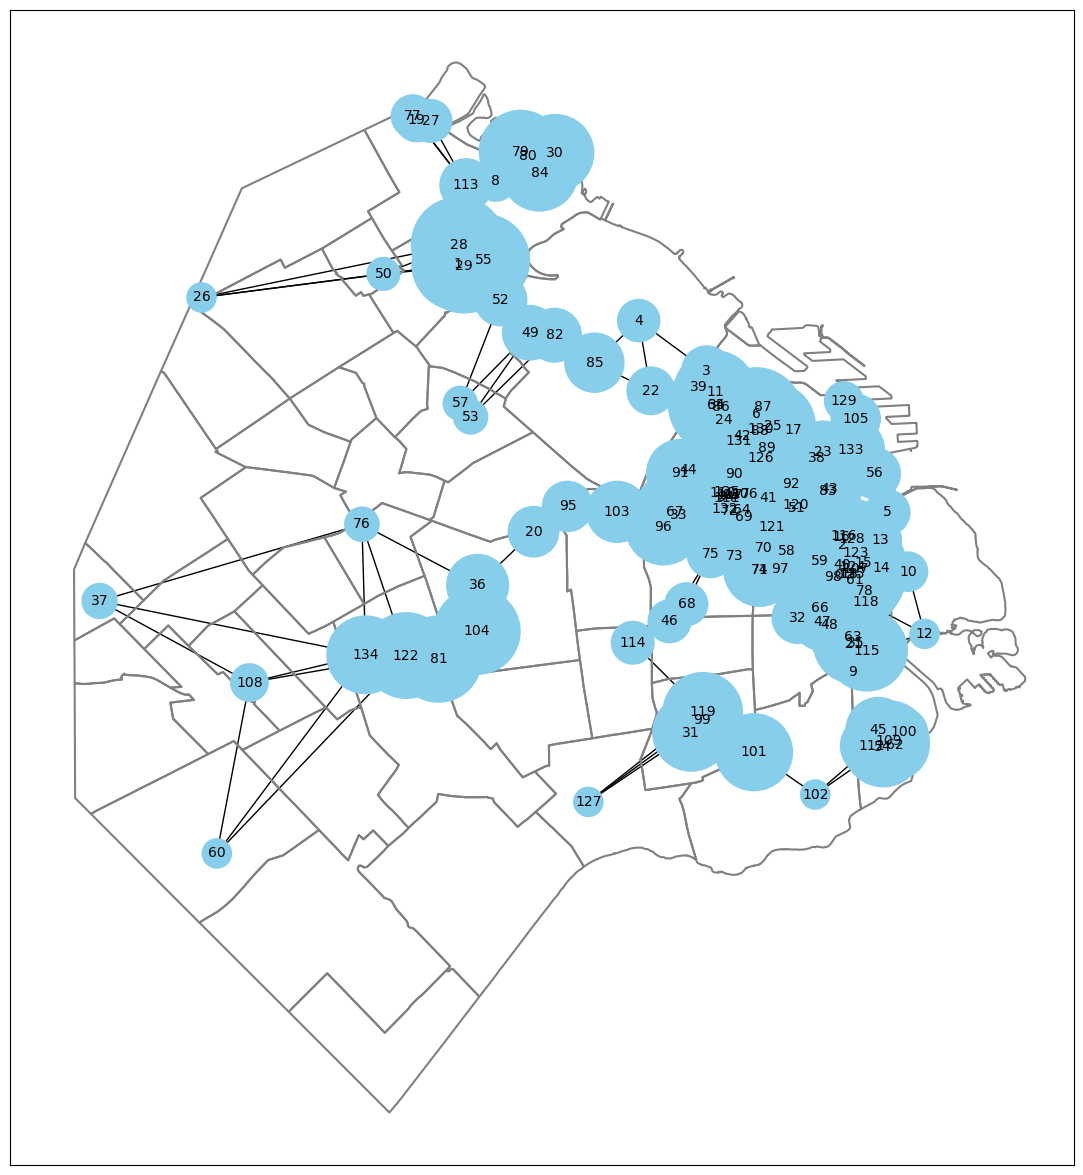

In [65]:
alfa = 0.2
pagerank = tf.calcula_pagerank(A,alfa)
node_sizes = [pagerank[n]*300000 for n in G.nodes]
fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)
nx.draw_networkx_nodes(G, G_layout, ax=ax, node_size=node_sizes, node_color='skyblue')
nx.draw_networkx_edges(G, G_layout, ax=ax)
nx.draw_networkx_labels(G, G_layout, ax=ax, font_size=10)
plt.show()

### Caso 2
Construyendo la red conectando a cada museo con sus $m$ vecinos más cercanos, para $m=1,3,5,10$ y usando $\alpha=\frac15$.
#### Respuesta
Puesto que $m=3$ y $\alpha=\frac{1}{5}$ ya fue analizado previamente, solo consideraremos $m=1,5,10$ para este punto.

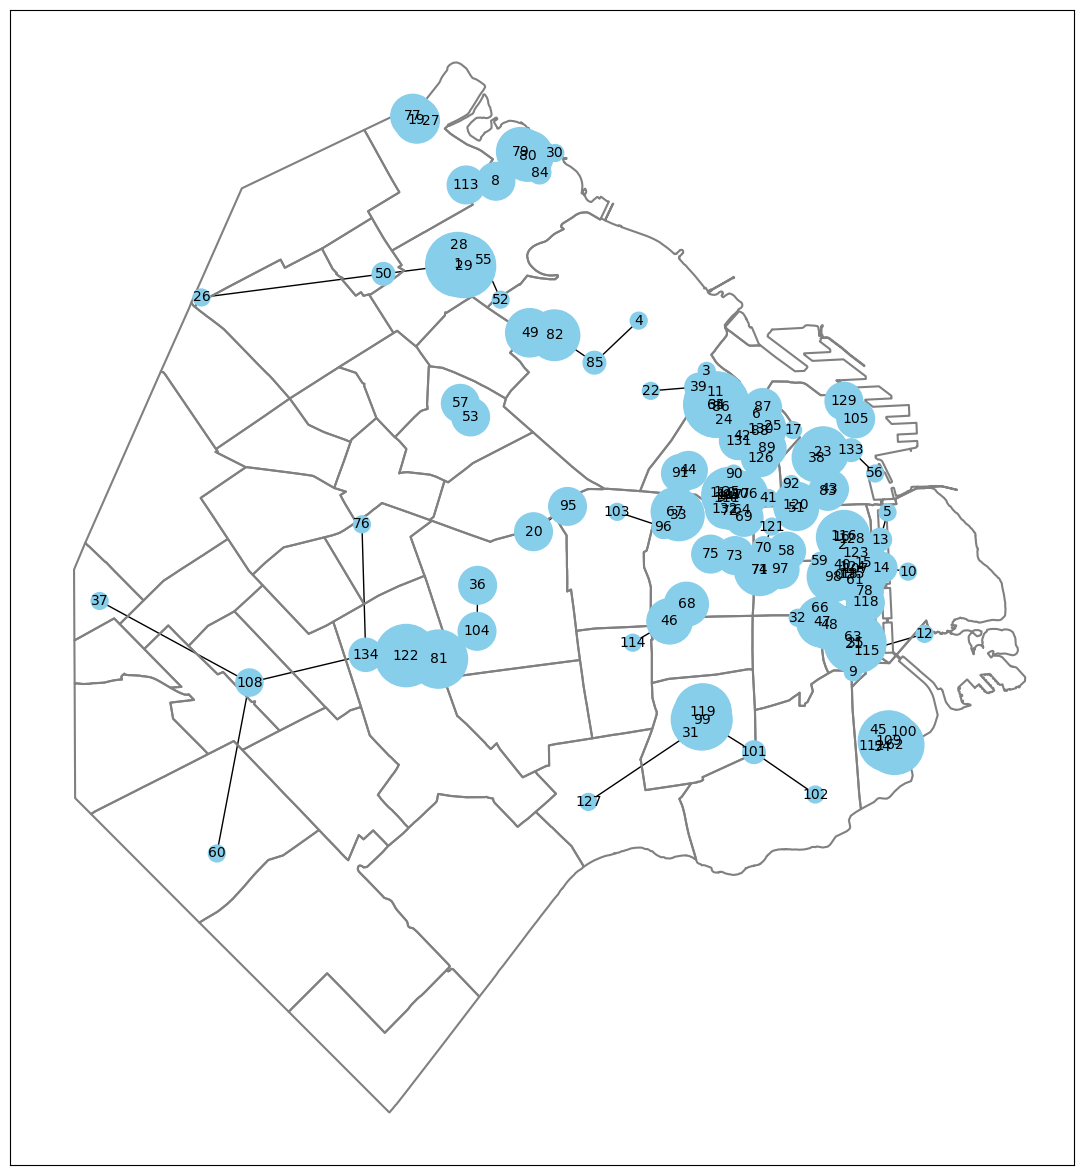

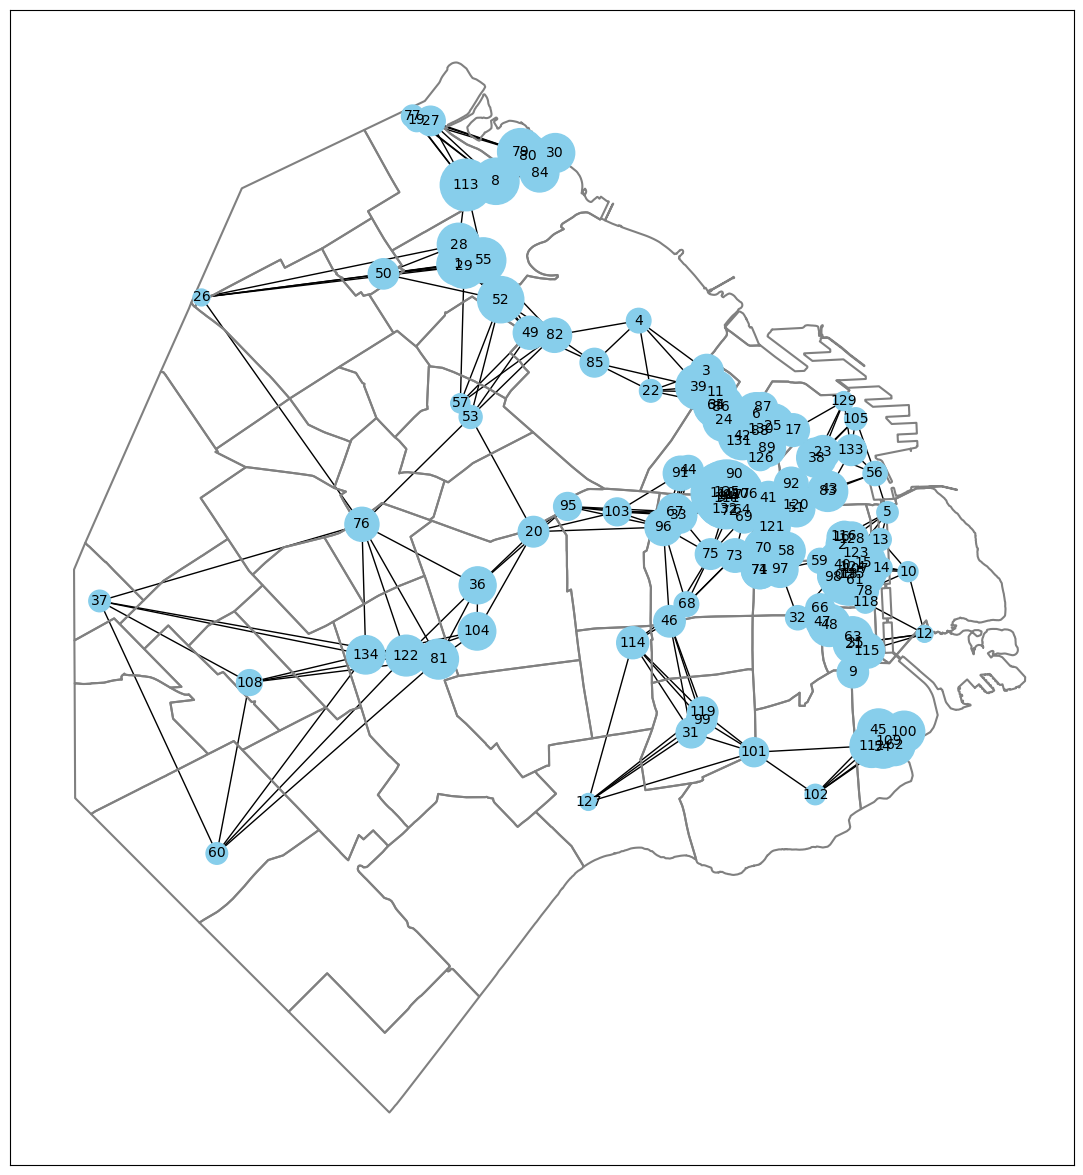

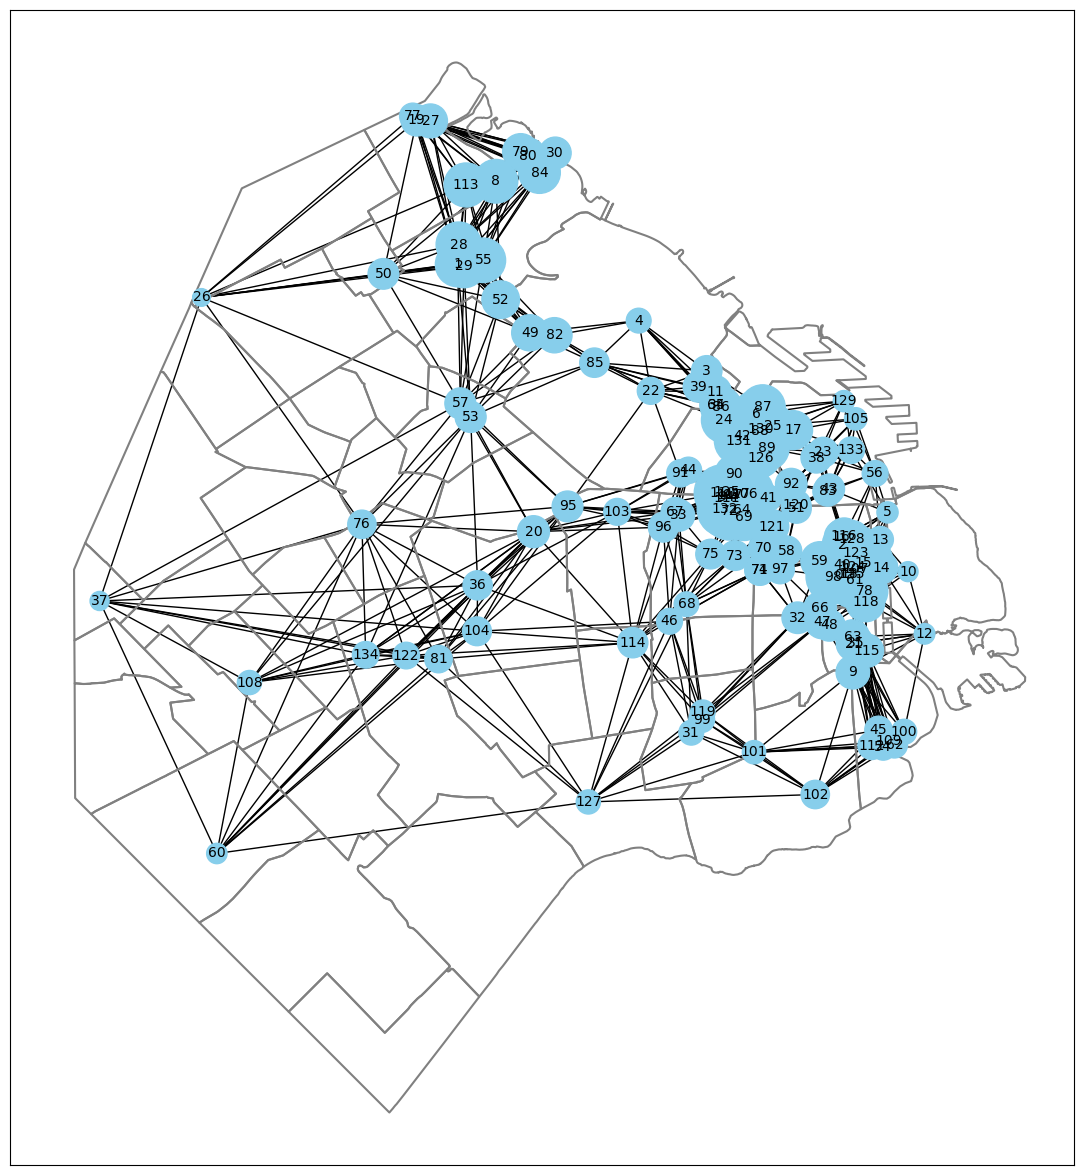

In [28]:
lista_m=[1,5,10]
for j in range(len(lista_m)):
  A_j = tf.construye_adyacencia(D,lista_m[j])
  pagerank = tf.calcula_pagerank(A_j,alfa)
  G_j = nx.from_numpy_array(A_j)
  G_j_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
  node_sizes = [pagerank[n]*100000 for n in G_j.nodes]
  fig, ax = plt.subplots(figsize=(15, 15))
  barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)
  nx.draw_networkx_nodes(G_j, G_j_layout, ax=ax, node_size=node_sizes, node_color='skyblue')
  nx.draw_networkx_edges(G_j, G_j_layout, ax=ax)
  nx.draw_networkx_labels(G_j, G_j_layout, ax=ax, font_size=10)
  plt.show()

### Caso 3
Para $m=5$, considerando los valores de $\alpha=\frac67,\frac45,\frac23,\frac12,\frac13,\frac15,\frac17$
#### Respuesta
Puesto que $\alpha=\frac15$ ya fue analizado para $m=5$, consideramos todos los otros valores $\alpha$.

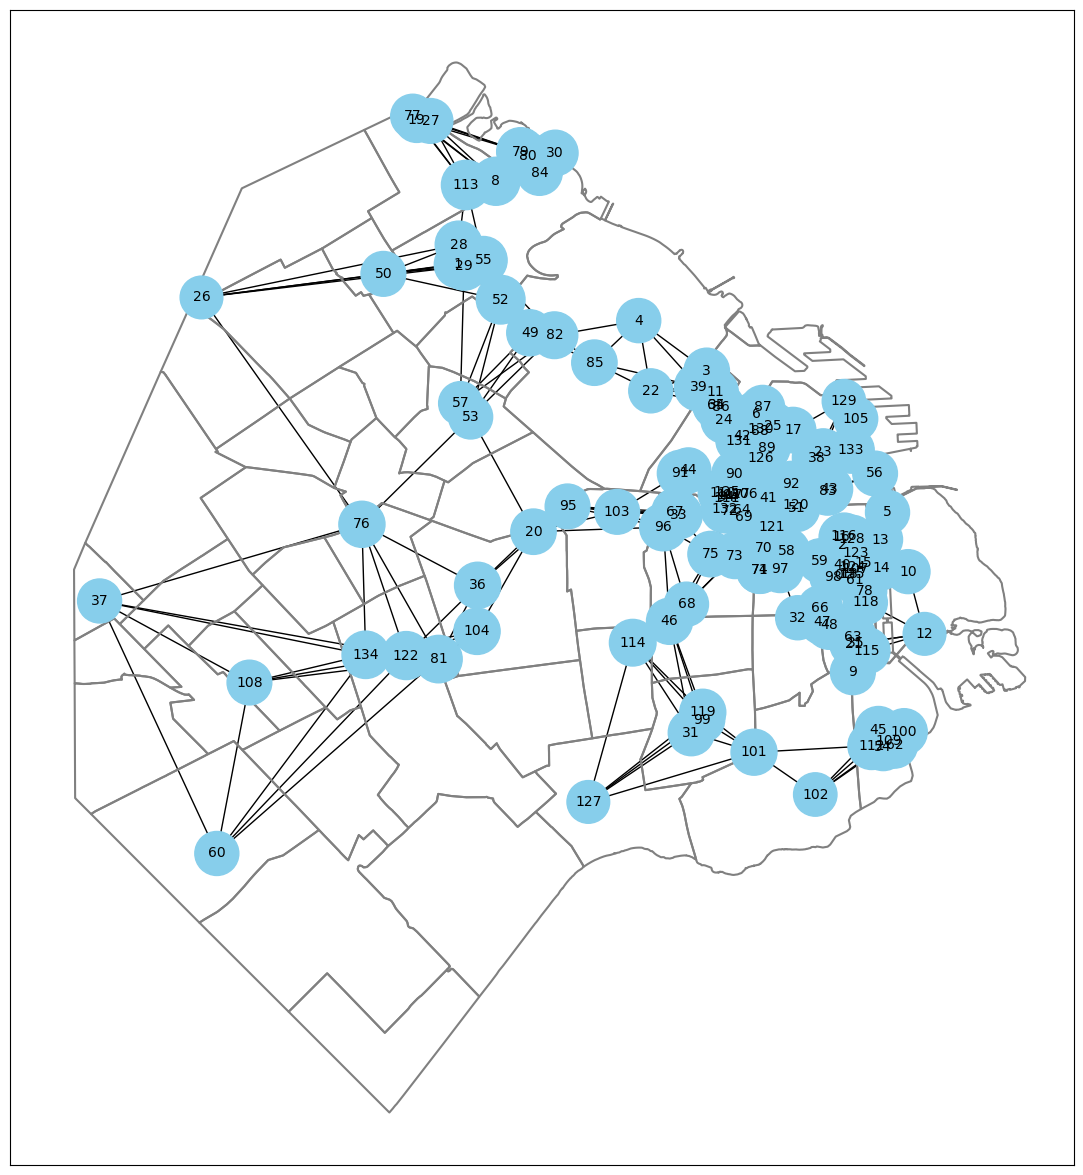

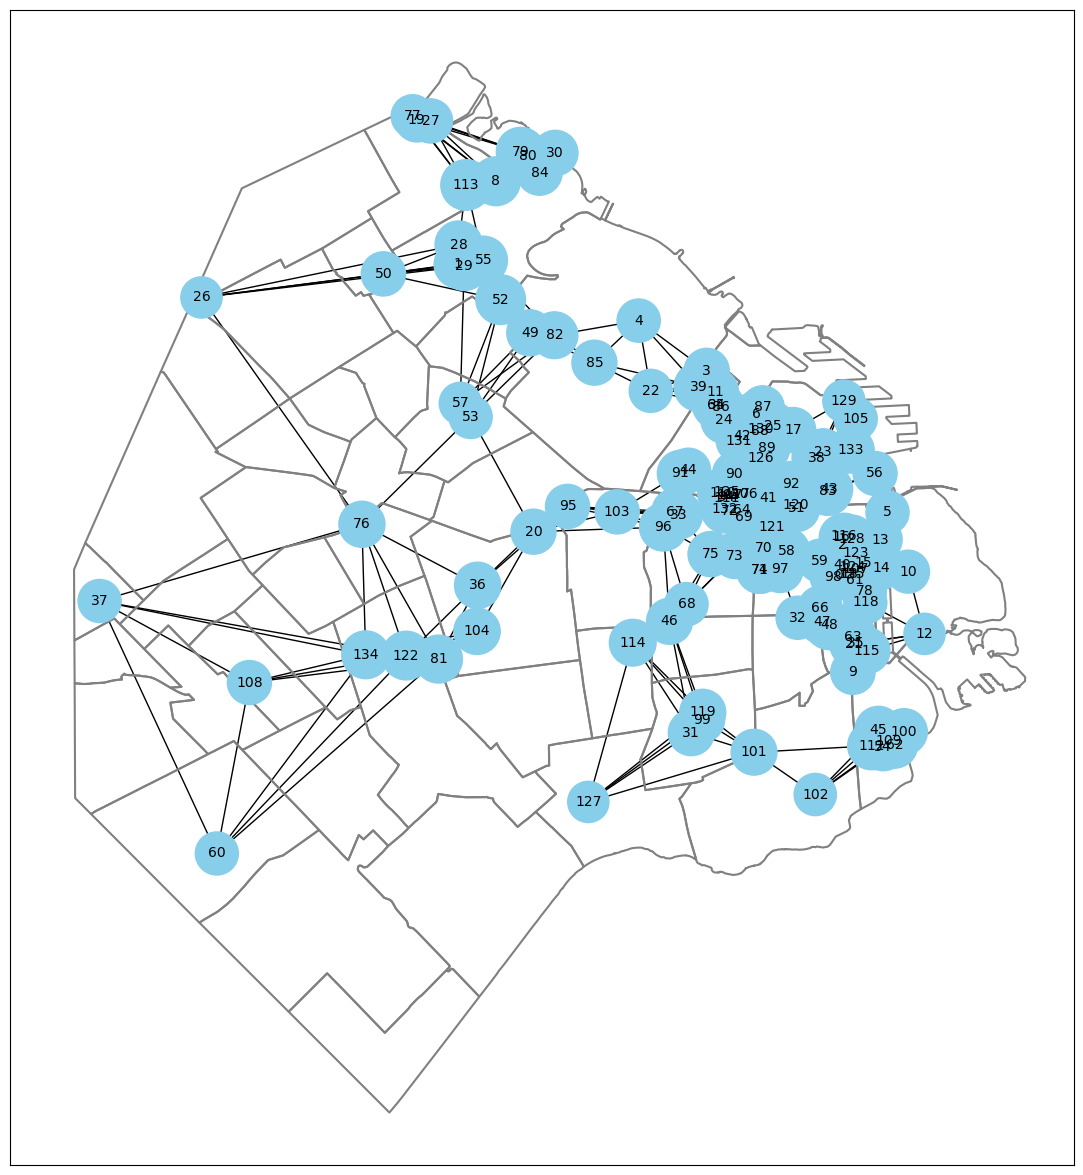

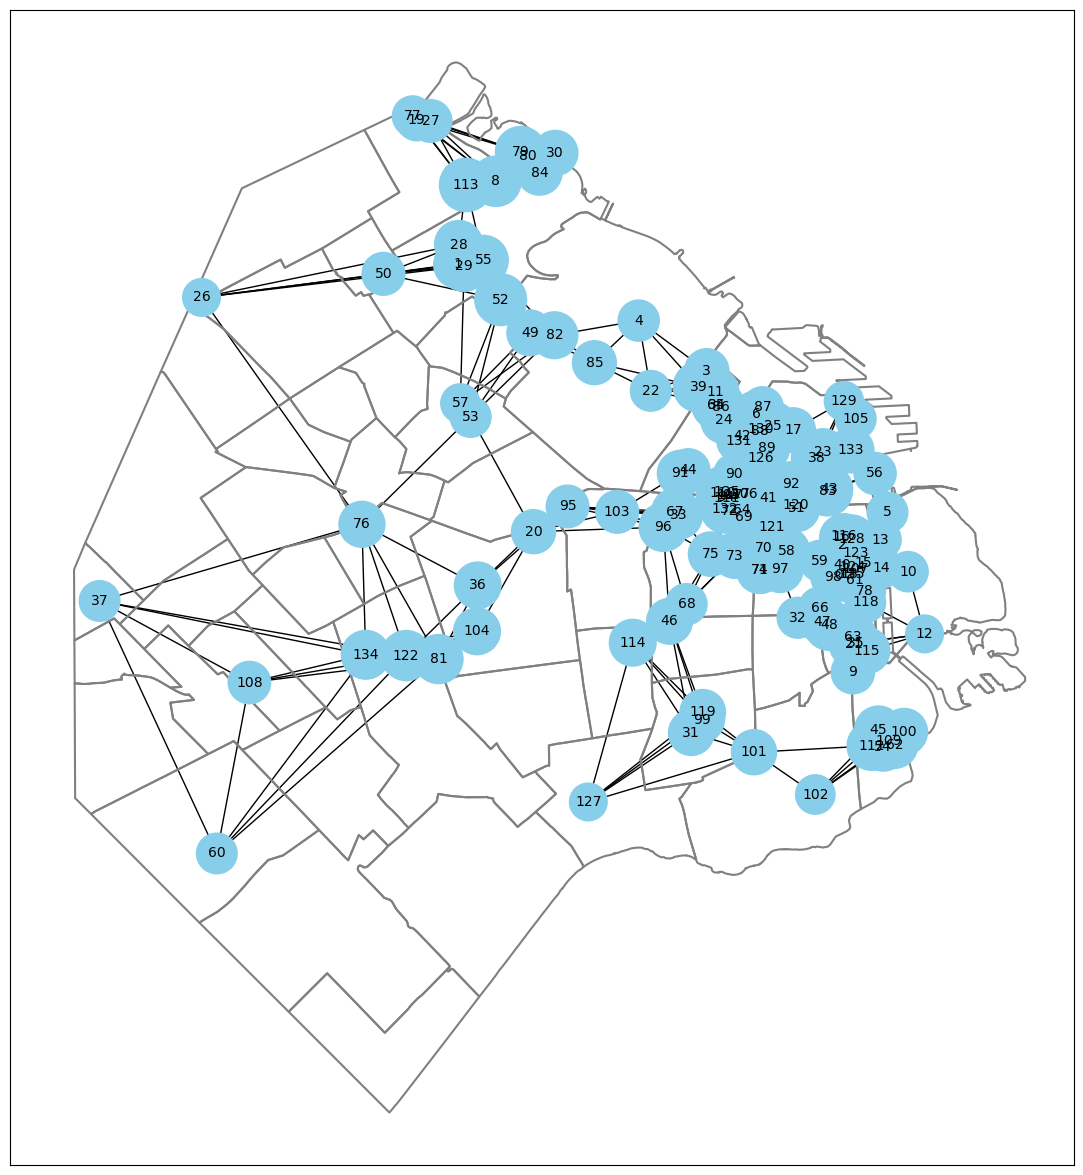

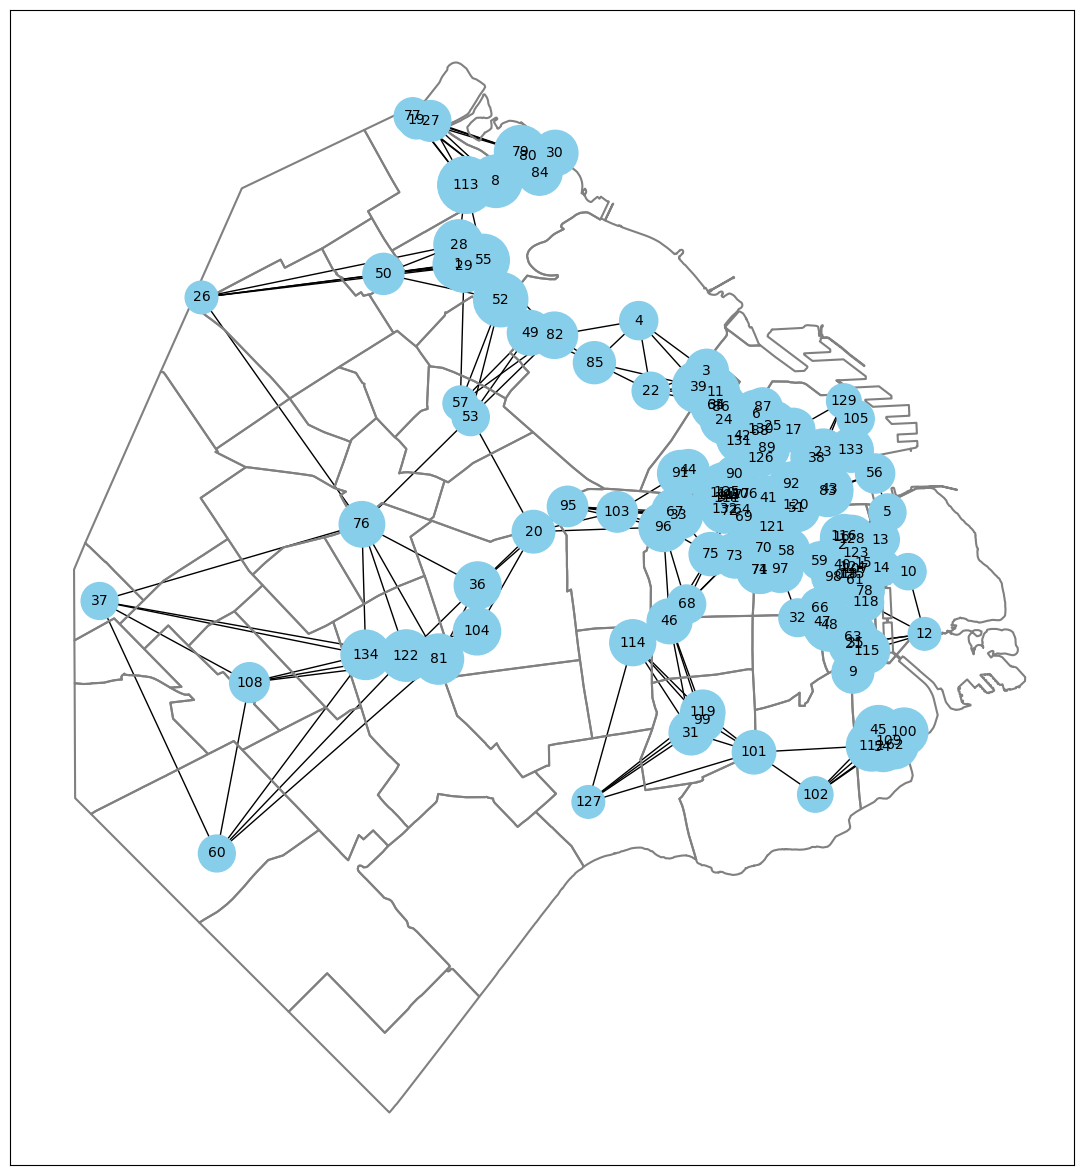

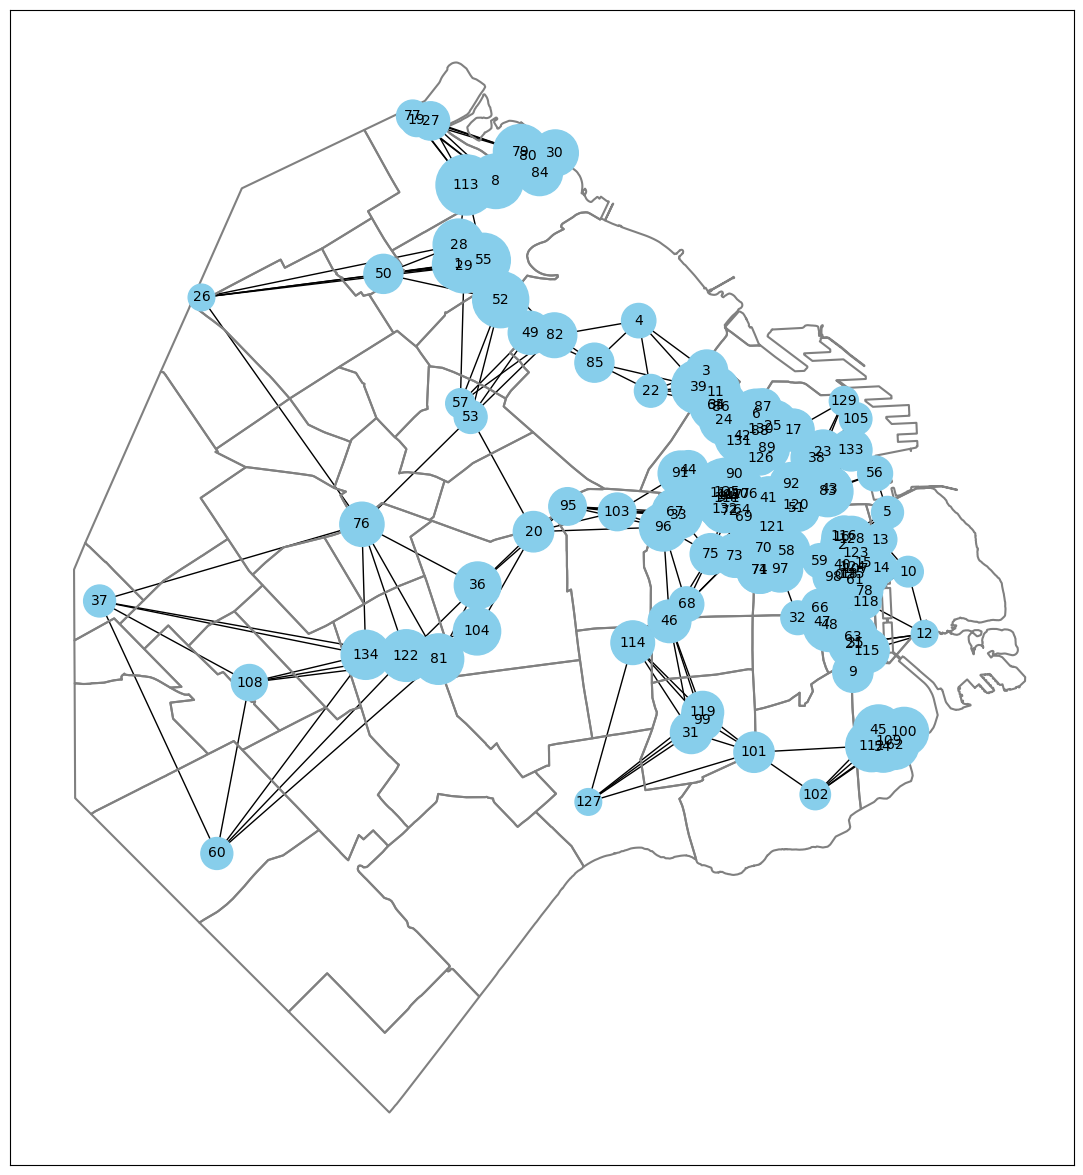

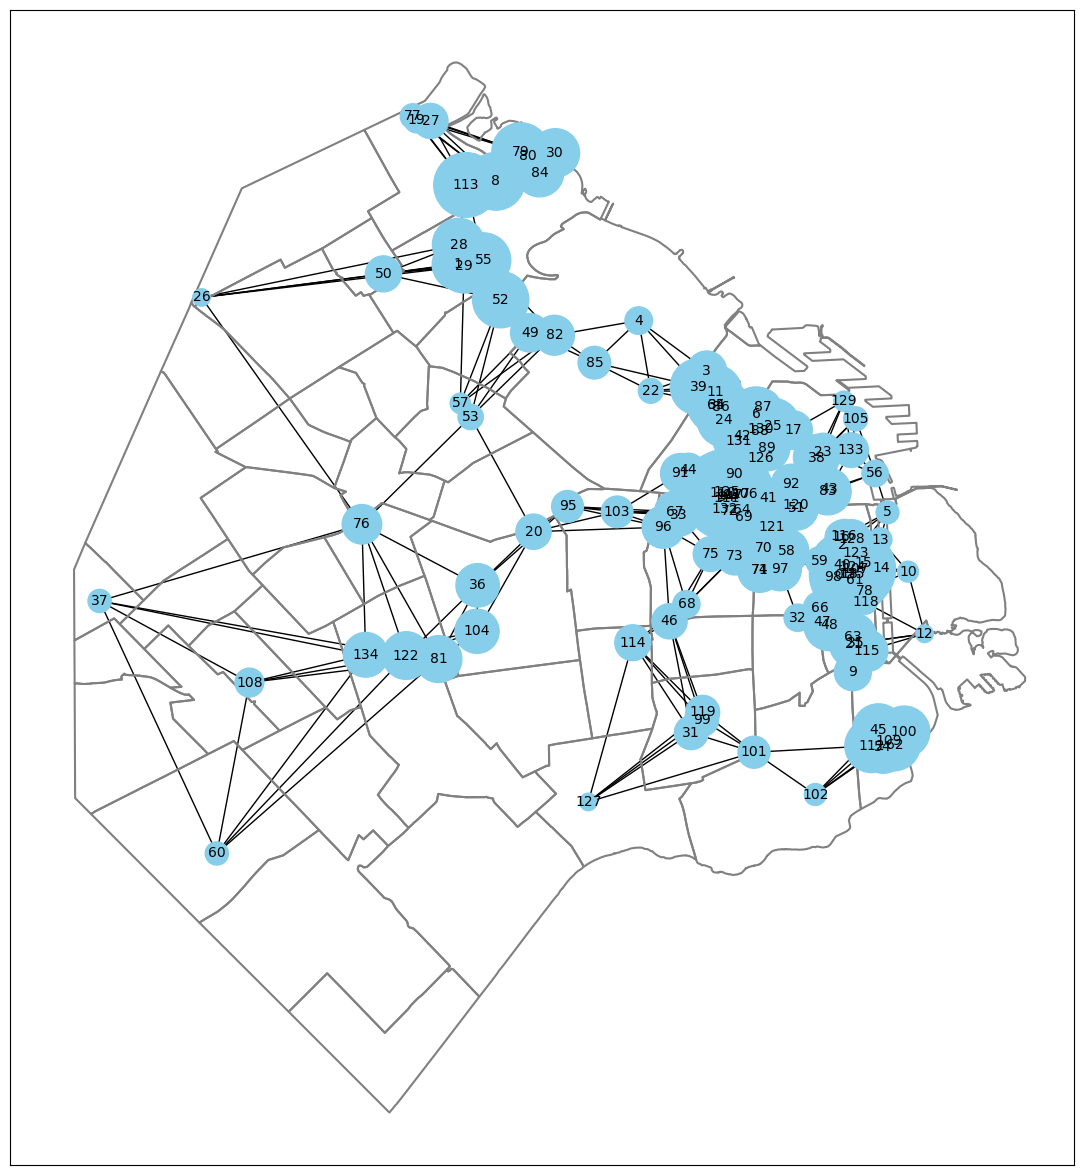

In [31]:
alfa_j = [6/7,4/5,2/3,1/2,1/3,1/7]
A_j = tf.construye_adyacencia(D,5)
G_j = nx.from_numpy_array(A_j)
G_j_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
for j in range(len(alfa_j)):
  pagerank = tf.calcula_pagerank(A_j,alfa_j[j])
  node_sizes = [pagerank[n]*150000 for n in G_j.nodes]
  fig, ax = plt.subplots(figsize=(15, 15))
  barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)
  nx.draw_networkx_nodes(G_j, G_j_layout, ax=ax, node_size=node_sizes, node_color='skyblue')
  nx.draw_networkx_edges(G_j, G_j_layout, ax=ax)
  nx.draw_networkx_labels(G_j, G_j_layout, ax=ax, font_size=10)
  plt.show()

### Caso 4
Identifiquen los 3 muesos más centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de *Page Rank*) en función del parámetro a variar (es decir, en función de $m$ o de $\alpha$). ¿Son estables las posiciones en el ranking? Describa los distintos patrones que obserrva, identificando qué ubicaciones son relevantes en cada caso. ¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?
#### Respuesta
Puesto que tenemos que analizar los 3 museos mas centrales en función de $\alpha$ y $m$, para analizar cada variable por separado tenemos que dejar la otra fija. De este modo, cuando analicemos en función de $\alpha$ definiremos $m=5$. En cambio, al analizar $m$, $\alpha=\frac15$.

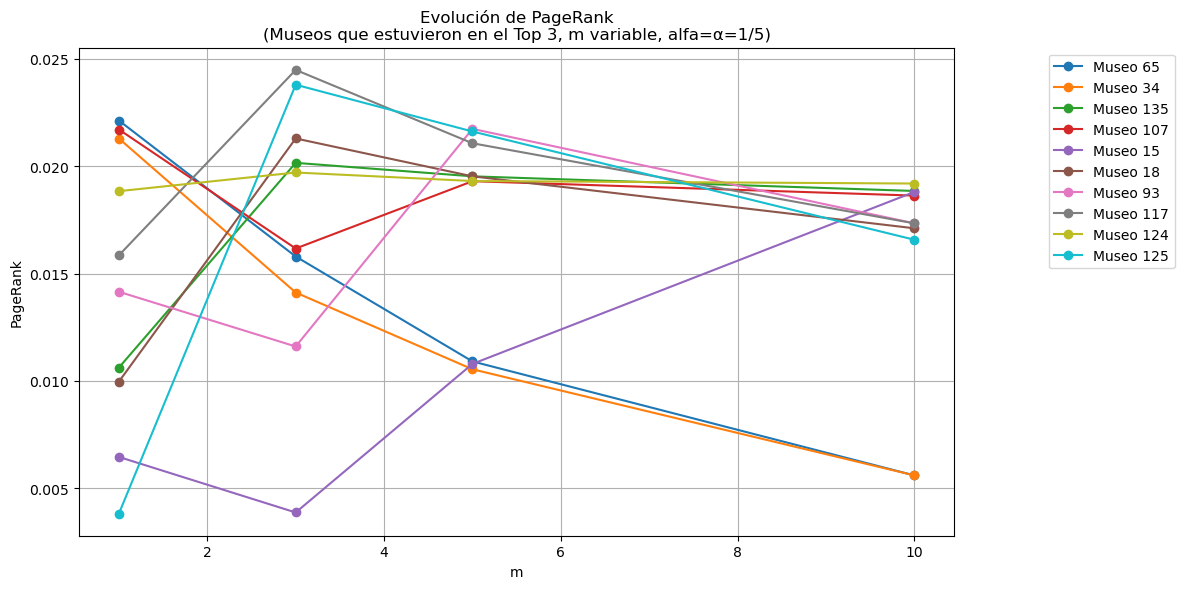

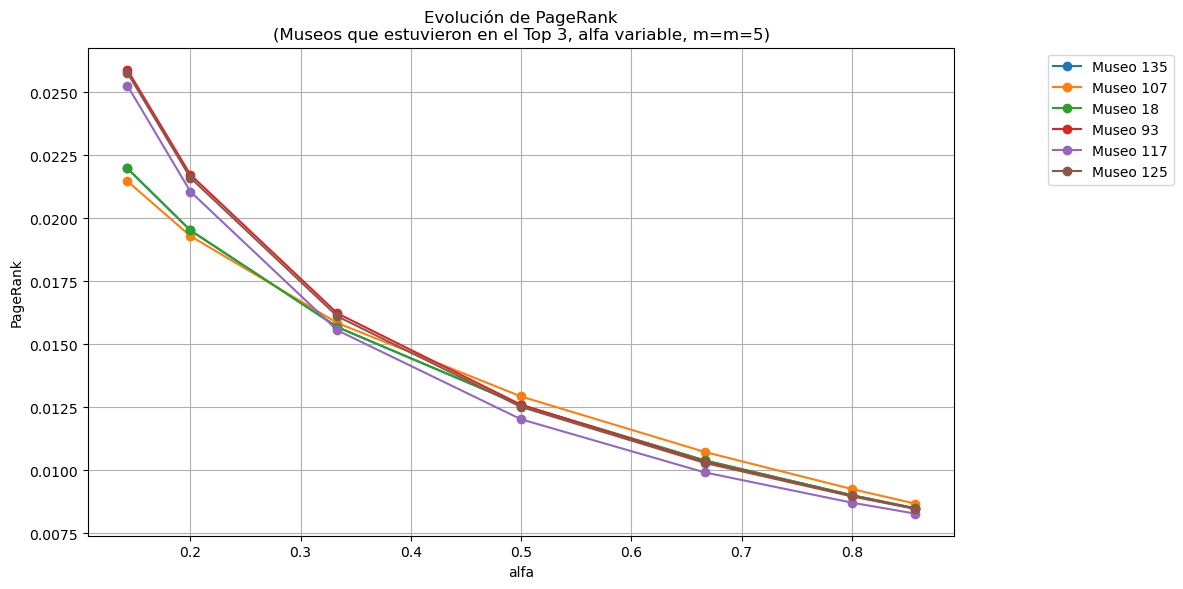

In [35]:
# Cantidad de museos (nodos)
cantidad_museos = D.shape[0]

# Diccionario con vectores de PageRank para distintos valores de m (con alfa = 1/5)
vectores_pagerank_por_m = {
    1: np.random.rand(cantidad_museos),
    3: np.random.rand(cantidad_museos),
    5: np.random.rand(cantidad_museos),
    10: np.random.rand(cantidad_museos)
}
alfa_fijo = 1/5

for m_actual in vectores_pagerank_por_m.keys():
    matriz_adyacencia = tf.construye_adyacencia(D, m_actual)
    vectores_pagerank_por_m[m_actual] = tf.calcula_pagerank(matriz_adyacencia, alfa_fijo)

# Diccionario con vectores de PageRank para distintos valores de alfa (con m = 5)
vectores_pagerank_por_alfa = {
    6/7: np.random.rand(cantidad_museos),
    4/5: np.random.rand(cantidad_museos),
    2/3: np.random.rand(cantidad_museos),
    1/2: np.random.rand(cantidad_museos),
    1/3: np.random.rand(cantidad_museos),
    1/5: np.random.rand(cantidad_museos),
    1/7: np.random.rand(cantidad_museos)
}
m_fijo = 5
adyacencia_fija = tf.construye_adyacencia(D, m_fijo)

for alfa_actual in vectores_pagerank_por_alfa.keys():
    vectores_pagerank_por_alfa[alfa_actual] = tf.calcula_pagerank(adyacencia_fija, alfa_actual)

# Analizamos los museos destacados en función de cada variable y cada constante según corresponda
df_por_m = tf.analiza_top_museos(vectores_pagerank_por_m, "m")
df_por_alfa = tf.analiza_top_museos(vectores_pagerank_por_alfa, "alfa")

# Graficar resultados para valores alfa o m fijos
tf.grafica_evolucion(df_por_m, "m", valor_fijo="α=1/5")
tf.grafica_evolucion(df_por_alfa, "alfa", valor_fijo="m=5")

Para el primer gráfico, donde variamos el valor de $m$, vemos que las posiciones en el ranking son inestables para cada museo. Esto es entendible puesto que estamos modificando la cantidad de "referencias" entre museos, de modo que se ve modificada la matriz de adyacencia, la cual define a las matrices $K$, $C$ y $M$. En consecuencia, el vector de puntajes $p$ se ve afectado, de modo que a menor cantidad de conexiones hay museos alejados de la zona céntrica de CABA que son más relevantes, y observamos que cuando $m$ tiende a valores grandes como $5$ o $10$, tenemos que los museos más importantes están concentrados en microcentro y barrios cercanos.
En el segundo gráfico, donde la variable es $\alpha$, observamos que las posiciones son más estables, aunque permiten cierta variación en los puestos. Sin embargo, vemos que a medida que crece $\alpha$ el puntaje de los museos decrece y convergen a un mismo valor. Esto tiene sentido pues $p=(1-\alpha)Cp+\frac\alpha N1$ y cuando $\alpha\to1$ tenemos que $p=\frac1 N1$, y para redes de numerosos museos cada puntaje $p_i\to0$.

## Punto 4:
Supongan que cada persona realiza $r$ visitas antes de abandonar la red de museos. Si el número total de visitas que recibió cada museo está dado por el vector $w$, tal que $w_i$ tiene el número total de visitantes que se recibieron en el museo $i$, muestres que el vector $v$, que tiene en su componente $v_i$ el número de personas que tuvo al museo $i$ como punto de entrada a la red, puede estimarse como:
$$v=B^{-1}w$$
con $B=\sum_{k=0}^{r-1}C^k$.
*Tip:* Recuerden que si $v$ da el número de visitantes que entraron a la red en cada museo, entonces luego de $k$ pasos podemos esperar la distribución $C^kv$ sobre el total de museos.
### Respuesta
Por enunciado tenemos que cada persona dentro de la red de museos realiza exactamente $r$ visitas antes de abandonarla. Luego, $v\in\mathbb{R}^n$ es el vector que indica, para cada museo $i$, la cantidad de personas que comenzaron su recorrido en ese museo. Además, $C\in\mathbb{R}^{n\times n}$ es una matriz que describe la distribución de los visitantes entre museos en cada paso (i.e., si un visitante se encuentra en un museo determinado, $C$ determina a qué otros museos podría ir en la siguiente visita). Entonces, si una persona inicia su recorrido según $v$, en el siguiente paso la distribución de visitantes será determinada por el producto $Cv$, después de dos pasos será $C^2v$, y así sucesivamente. De este modo, pasados $k$ pasos, la distribución esperada será $C^kv$.

Si consideramos solamente las visitas subsiguientes a la inicial (todas menos $v$), tenemos que cada persona hace $r-1$ movimientos. De este modo, el número total de visitas que recibe cada museo es la suma de todas estas distribuciones. Por lo tanto, el vector total de visitas $w$ que cuenta cuántas veces fue visitado cada museo (sin importar si fue la primera o una subsiguiente), se puede expresar como:
$$w=v+Cv+C^2v+\cdots+C^{r-1}v$$
Siendo que toda matriz cuadrada $A^0=I$, y factorizando $v$ en esta expresión, tenemos que:
$$w=(I+C+C^2+\cdots+C^{r-1})v\implies w=\left(\sum_{k=0}^{r-1}C^k\right)v$$
Como por enunciado tenemos que
$$B=\sum_{k=0}^{r-1}C^k$$
entonces se cumple que $w=Bv$. Suponiendo que la matriz $B$ es invertible, podemos despejar $v$ multiplicando ambos lados de la ecuación por $B^{-1}$, lo que nos da
$$v=B^{-1}w$$
como se quería demostrar.

## Punto 5:
Usando la ecuación anterior, $v=B^{-1}w$, y suponiendo que las personas dan $r=3$ pasos en la red de muesos, calcular la cantidad total de visitantes que entraron en la red, $||v||_1$, a partir del vector $w$ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida por la ecuación
$$C_{ji}=P(i\to j)=\frac{f(d_{ij})}{\sum_{k=1,k\neq i}^Nf(d_{ik})}$$
Para esto:
- Construya una función `calcula_matriz_C_continua` que reciba la matriz de distancias entre museos $D$ y retorne la matriz $C$ definida en la ecuación anterior.
- Construya una función `calcula_B(C,r)` que reciba la matriz $C$ y el número de pasos $r$ como argumento, y retorne la matriz $B$ de la ecuación $v=B^{-1}w$.
- Utilice la función `calculaLU`para resolver la ecuación $v=B^{-1}w$.

In [40]:
C_cont = tf.calcula_matriz_C_continua(D)
B = tf.calcula_B(C_cont,3)
w = np.loadtxt('visitas.txt')

L, U = tf.calcularLU(B)

y = sp.linalg.solve_triangular(L,w, lower = True)
v = sp.linalg.solve_triangular(U,y)

print(v)

[1218.87436007  555.18106065 1376.12643949 1358.03131768  707.3407779
 1127.11933157  995.61735034 1224.14856459  557.62139715  937.43660117
  647.89183564  652.89726223 1083.78520226 1147.58224574  804.99946263
  958.50186548 1020.22110458 1286.54398821 1024.08347446 1486.29645152
  712.72750657  628.8528416   727.13715287  908.03518286  657.58194949
  843.76601231  666.77443582 1392.04027966  666.95989684 1184.15599728
 1468.07312642  884.90176649 1295.52935564  641.89426588  957.01635365
 1351.57862836 1497.00931159 1064.171676    920.09318813  760.97532931
  697.8871831  1052.20714005 1361.56400699 1137.46293853  830.46466218
  582.96462279 1467.327095   1470.11837361  511.89298695 1288.51531843
  597.04405759 1406.20232498 1176.0308105   575.30399735  994.82276372
 1328.23905196 1408.15480027 1336.08826063  774.98908363  937.228022
  764.23080572  570.61627821 1268.09175651 1160.56081573  547.26572823
  966.7545758  1209.50902102 1209.86791683  902.35888976 1386.93456764
  836.900

## Punto 6:
Supongan que se enteran de que el número total de visitantes tiene un error del $5\%$, y necesitan estimar cómo se propaga ese error a la estimación del número inicial de visitantes. Llamemos $\tilde{w}$ y $\tilde{v}$ son los valores reales para el total de visitas y el total de primeras visitas respectivamente. Si expresamos este problema usando el número de condición tenemos que
$$\frac{||v-\tilde{v}||_1}{||v||_1}\leq\text{cond}_1(B)\frac{||w-\tilde{w}||_1}{||w||_1}$$
Calcule el número de condición de $B$ y estime la cota para el error de estimación de $v$.
### Respuesta
Como por enunciado tenemos que $\frac{||w-\tilde{w}||_1}{||w||_1}=0.05$, entonces procedemos a calcular el número de condición asociado a la norma-1 de $B$.

Conocemos que $\text{Cond}_1(B)=||B||_1||B^{-1}||_1$. Utilizando la factorización $LU$ de $B$, podemos calcular su inversa con la implementación de la función `inversa_por_LU`.

In [57]:
normaB = np.linalg.norm(B,ord=1)
B_inv = tf.inversaPorLU(B)
normaB_inv = np.linalg.norm(B_inv,ord=1)
condicionB = normaB * normaB_inv

print(f"Numero de Condición: {np.round(condicionB,4)}")

Numero de Condición: 5.0518


Como el valor obtenido para el número de condición es
$$\text{cond}_1(B)\approx5.05$$
y siendo que el error relativo en $w$ es del $5\%$, al aplicar la desigualdad de propagación de errores tenemos que:
$$\frac{||v-\tilde{v}||_1}{||v||_1}\leq 5.05\cdot0.05=0.2526$$

In [59]:
errorRel_w = 0.05
errorRel_v = errorRel_w * condicionB

print(f"Cota del error relativo de v: {np.round(errorRel_v*100,4)}%")

Cota del error relativo de v: 25.2589%


Por lo tanto, la cota para el error relativo en la estimación de $v$ es aproximadamente del $25.26\%$. Esto indica que incluso un pequeño error en el total de visitas puede amplificarse significativamente al estimar el número de primeras visitas, lo cual resalta la importancia de tener una matriz $B$ bien condicionada o datos $w$ con alta precisión.

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, '17'),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 1

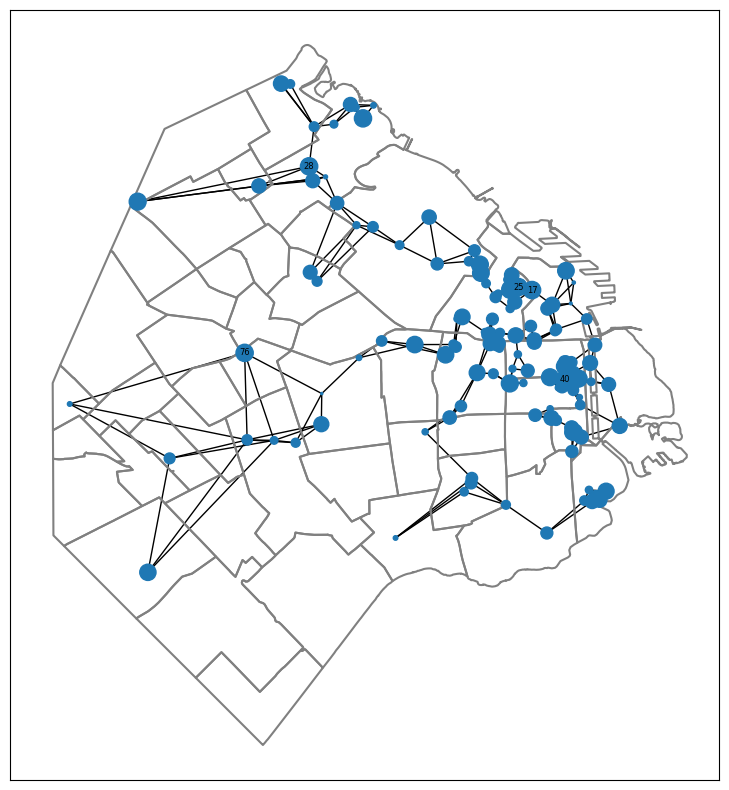

In [63]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres